# Examples 3: ISL Chapter 8 (James Hughes)

## Pre-Amble

In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import ConfusionMatrixDisplay

In [126]:
oj_df = pd.read_csv("OJ.csv").drop(columns=["Unnamed: 0"])

## Question 9

### Question 9.a.

In [127]:
oj_df.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


In [128]:
oj_df["Purchase"].value_counts()

Purchase
CH    653
MM    417
Name: count, dtype: int64

In [129]:
display(oj_df.describe(include=["int", "float"]))

,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
count,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000
mean,254.381308,3.959813,1.867421,2.085411,0.051860,0.123364,0.147664,0.161682,0.565782,1.962047,1.815561,0.146486,0.059298,0.027314,0.217991,1.630841
std,15.558286,2.308984,0.101970,0.134386,0.117474,0.213834,0.354932,0.368331,0.307843,0.252697,0.143384,0.271563,0.101760,0.062232,0.107535,1.430387
min,227.000000,1.000000,1.690000,1.690000,0.000000,0.000000,0.000000,0.000000,0.000011,1.190000,1.390000,-0.670000,0.000000,0.000000,0.000000,0.000000
25%,240.000000,2.000000,1.790000,1.990000,0.000000,0.000000,0.000000,0.000000,0.325257,1.690000,1.750000,0.000000,0.000000,0.000000,0.140000,0.000000
50%,257.000000,3.000000,1.860000,2.090000,0.000000,0.000000,0.000000,0.000000,0.600000,2.090000,1.860000,0.230000,0.000000,0.000000,0.240000,2.000000
75%,268.000000,7.000000,1.990000,2.180000,0.000000,0.230000,0.000000,0.000000,0.850873,2.130000,1.890000,0.320000,0.112676,0.000000,0.300000,3.000000
max,278.000000,7.000000,2.090000,2.290000,0.500000,0.800000,1.000000,1.000000,0.999947,2.290000,2.090000,0.640000,0.402010,0.252688,0.440000,4.000000


In [130]:
display(oj_df.describe(include=["object"]))

,Purchase,Store7
count,1070,1070
unique,2,2
top,CH,No
freq,653,714


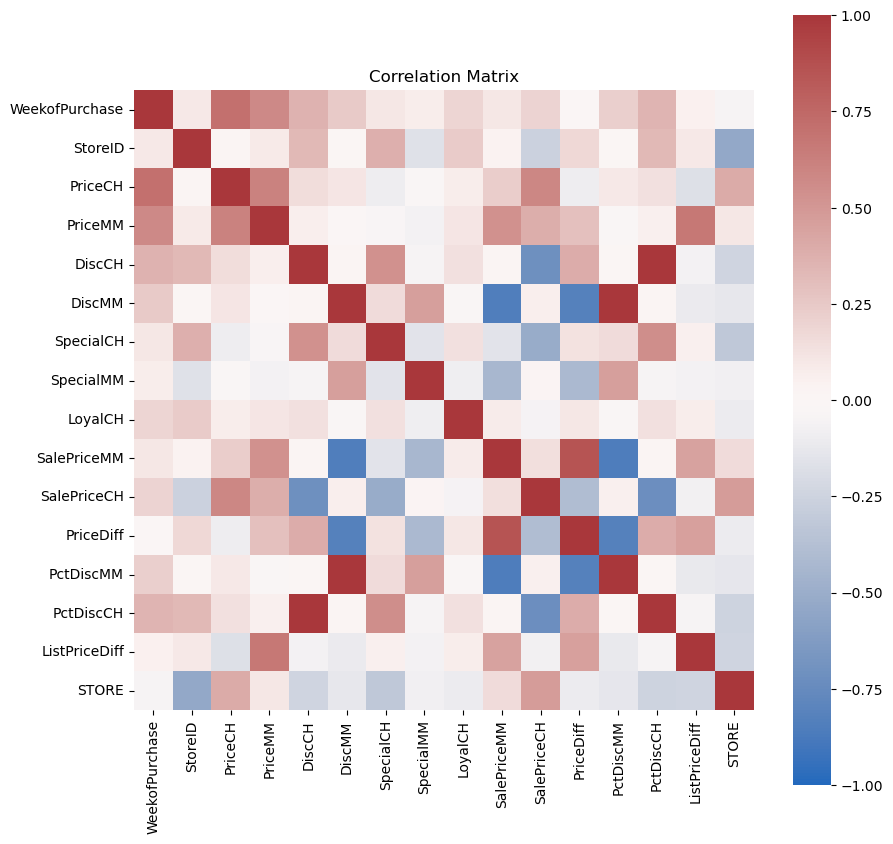

In [131]:
corr = oj_df.drop(columns=["Purchase", "Store7"]).corr()
fig = plt.figure(figsize=(10, 10))
_ = sns.heatmap(corr, square=True, cbar=True, cmap="vlag", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

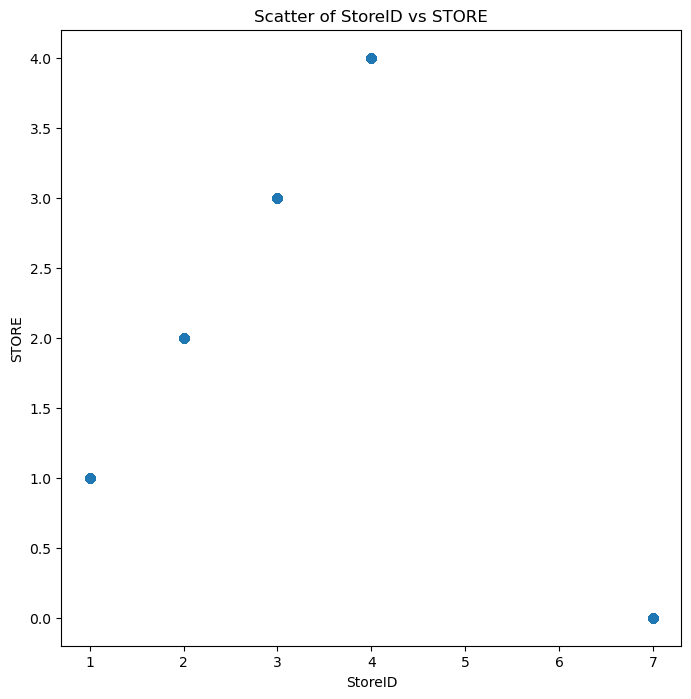

In [132]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()
ax.scatter(data=oj_df, x="StoreID", y="STORE")
ax.set(title="Scatter of StoreID vs STORE", xlabel="StoreID", ylabel="STORE")
plt.show()

From the exploratory analysis, we make some decisions in terms of preprocessing:
 - STORE is clearly a cleaned version of the StoreID variable, where intermediate values that did not appear are removed from the range. So we remove StoreID from the dataset.
 - STORE should be treated as a discrete variable, and thus deserves a one-hot encoding.
 - This one-hot encoding will also make the Store7 variable redundant, and thus we remove that too.
 - SalePriceMM, SalePriceCH, and PriceDiff are all correlated; we keep only the PriceDiff as the (most informative) representative. This also helps since the SalePrice variables are correlated with PctDisc variables.
 - The PctDisc variables are correlated with their corresponding Disc variables, hence we remove the later keeping the PctDisc variables as representatives.
 - Although the Special variables are discrete they are binary, so require no pre-processing.
 
(The link https://islp.readthedocs.io/en/latest/datasets/OJ.html was useful in helping to understand the variables and make these decisions.)

In [136]:
oj_df = oj_df.drop(columns=["StoreID", "DiscCH", "DiscMM", "SalePriceMM", "SalePriceCH", "Store7"])

In [138]:
ohe_STORE = pd.get_dummies(oj_df["STORE"], prefix="store", drop_first=False, dtype=int)
oj_df = oj_df.join(ohe_STORE).drop(columns=["STORE"])

X = np.array(oj_df.drop(columns=["Purchase"]))

In [147]:
label_ec_y = LabelEncoder()
y = label_ec_y.fit_transform(oj_df["Purchase"])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=800, random_state=42)

In [153]:
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [163]:
print("Training error rate is: {:.5f}".format(1 - dt_clf.score(X_train, y_train)))

Training error rate is: 0.00750


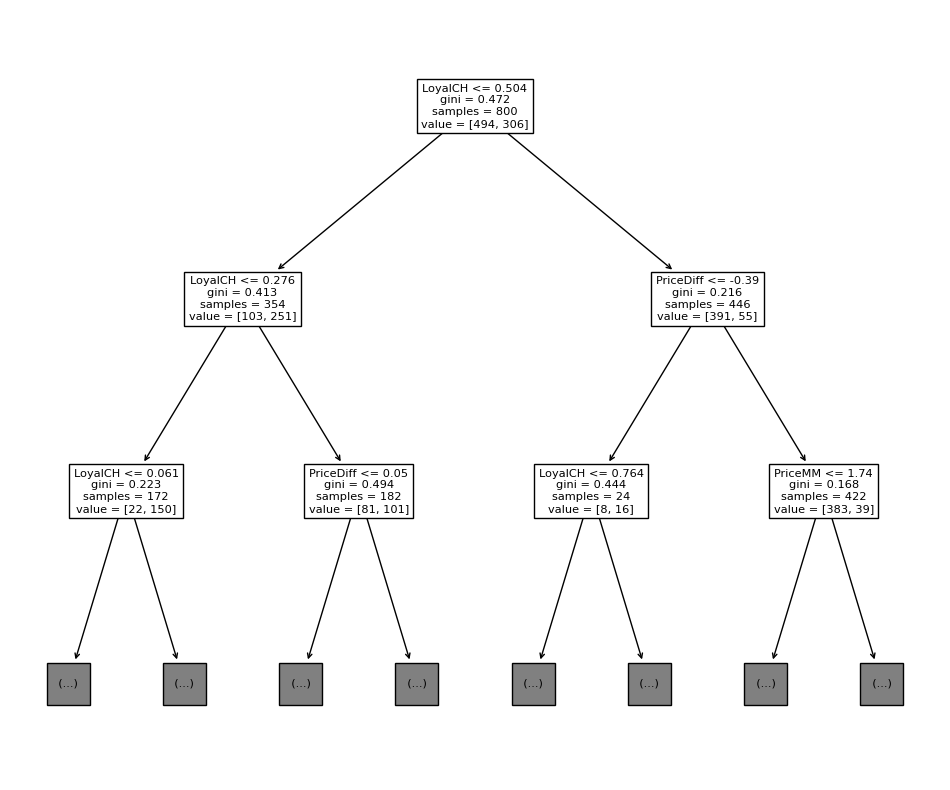

In [155]:
feature_names = list(oj_df.drop(columns=["Purchase"]).columns)
fig = plt.figure(figsize=(12, 10))
_ = plot_tree(dt_clf, max_depth=2, feature_names=feature_names)
plt.show()

In [167]:
print("Number of terminal nodes: {}".format(dt_clf.get_n_leaves()))

Number of terminal nodes: 167


In [157]:
print(export_text(dt_clf, feature_names=feature_names))

|--- LoyalCH <= 0.50
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.06
|   |   |   |--- WeekofPurchase <= 268.50
|   |   |   |   |--- class: 1
|   |   |   |--- WeekofPurchase >  268.50
|   |   |   |   |--- PriceDiff <= 0.29
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- PriceDiff >  0.29
|   |   |   |   |   |--- class: 0
|   |   |--- LoyalCH >  0.06
|   |   |   |--- LoyalCH <= 0.21
|   |   |   |   |--- WeekofPurchase <= 273.00
|   |   |   |   |   |--- WeekofPurchase <= 261.00
|   |   |   |   |   |   |--- PriceDiff <= -0.13
|   |   |   |   |   |   |   |--- WeekofPurchase <= 240.00
|   |   |   |   |   |   |   |   |--- WeekofPurchase <= 236.50
|   |   |   |   |   |   |   |   |   |--- WeekofPurchase <= 234.00
|   |   |   |   |   |   |   |   |   |   |--- LoyalCH <= 0.16
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- LoyalCH >  0.16
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   

In [146]:
label_ec_y.classes_

array(['CH', 'MM'], dtype=object)

We see that the first terminal node corresponds to a prediction of class 1 if
 - LoyalCH <= 0.06
 - WeekofPurchase <= 268

In simpler terms, the tree predicts a purchase of a Minute Maid orange juice if the LoyalCH variable is low, and the purchase date was early (relative to the data from the dataset).

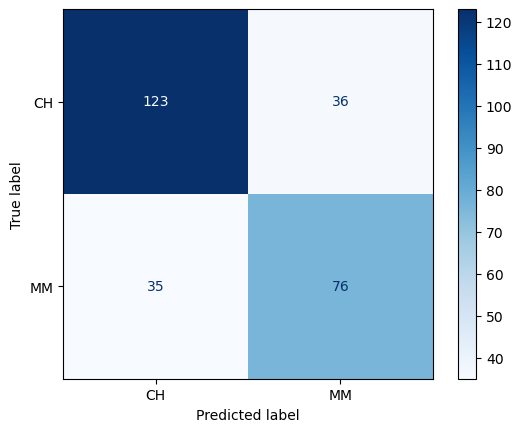

Test error rate: 0.26296


In [171]:
ConfusionMatrixDisplay.from_estimator(dt_clf, X_test, y_test, display_labels=label_ec.classes_, cmap=plt.cm.Blues)
plt.show()
print("Test error rate: {:.5f}".format(1 - dt_clf.score(X_test, y_test)))

### Question 9.f. Cross-Validation & Tuning

In [215]:
ccp_path = DecisionTreeClassifier().cost_complexity_pruning_path(X_train, y_train) 

In [217]:
np.log(0.0001+ccp_path.ccp_alphas)

array([-9.21034037, -7.56811264, -7.56811264, -7.56811264, -7.56811264,
       -7.23522058, -7.2293389 , -7.18910822, -7.17345844, -7.11319925,
       -7.07027421, -7.0540664 , -7.02241819, -6.97674815, -6.87094131,
       -6.87094131, -6.8124451 , -6.8124451 , -6.8124451 , -6.8124451 ,
       -6.7752661 , -6.7752661 , -6.76132665, -6.74953127, -6.74953127,
       -6.73065567, -6.70481443, -6.6903424 , -6.68795063, -6.66726309,
       -6.66046127, -6.64890757, -6.62572138, -6.62527539, -6.62373734,
       -6.62156686, -6.60765069, -6.60765069, -6.55924327, -6.48342169,
       -6.45630506, -6.43775165, -6.43301637, -6.42298033, -6.38389004,
       -6.37241773, -6.36993958, -6.32543121, -6.32068112, -6.22718688,
       -6.16770026, -6.14949836, -6.14175904, -6.13896515, -6.12690252,
       -6.03115443, -6.02177579, -6.00157655, -5.87763995, -5.68147726,
       -5.62614674, -5.57642422, -5.52691029, -5.49676831, -5.49442584,
       -5.00604392, -4.97932393, -4.27222326, -3.97277924, -3.80

In [233]:
ccp_path = DecisionTreeClassifier().cost_complexity_pruning_path(X_train, y_train) 

dt_cv = GridSearchCV(DecisionTreeClassifier(), param_grid={"ccp_alpha": np.unique(ccp_path.ccp_alphas)}, cv=5, refit=True)

dt_cv.fit(X_train, y_train)

dt_results = pd.DataFrame(dt_cv.cv_results_).drop(columns=["params"]).astype("float")

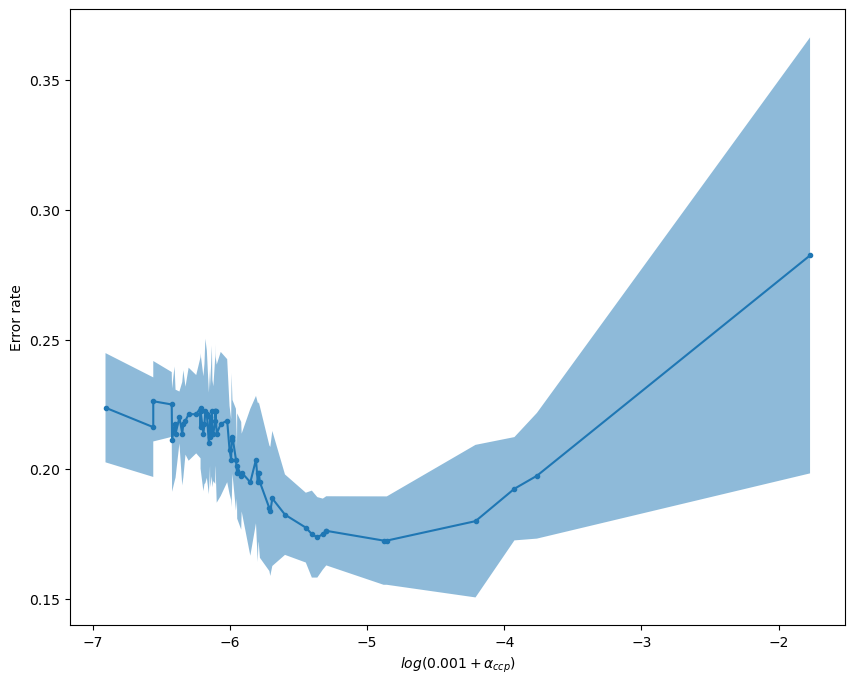

In [260]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()

ax.plot(np.log(1e-3+dt_results["param_ccp_alpha"]), 1 - dt_results["mean_test_score"], marker=".")
ax.fill_between(np.log(1e-3+dt_results["param_ccp_alpha"]), 1 - dt_results["mean_test_score"] + dt_results["std_test_score"],
                1 - dt_results["mean_test_score"] - dt_results["std_test_score"], alpha=.5)
ax.set_xlabel(r"$log(0.001 + \alpha_{ccp}$)")
ax.set_ylabel("Error rate")

plt.show()